<a href="https://colab.research.google.com/github/leehanchung/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here
random.seed(10) # set random seed for reproducibility

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=172.07500125969045, mobile=False), User(purchased=False, time_on_site=242.1604565076447, mobile=True), User(purchased=True, time_on_site=172.4562884302345, mobile=True), User(purchased=False, time_on_site=134.30741730988564, mobile=True), User(purchased=False, time_on_site=176.6659151415657, mobile=False), User(purchased=False, time_on_site=98.57704667574383, mobile=True), User(purchased=False, time_on_site=141.90635886960914, mobile=True), User(purchased=False, time_on_site=46.30954508769639, mobile=True), User(purchased=True, time_on_site=568.9570603645093, mobile=False), User(purchased=False, time_on_site=64.57737234489078, mobile=True)]


In [4]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,172.075001,False
1,False,242.160457,True
2,True,172.456288,True
3,False,134.307417,True
4,False,176.665915,False


In [5]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.167894147962072,5.230051694531813,5.859655940198439,6.0175026563650755,6.029351938631506,6.076534025386882,7.530625255773601,7.817115390608255,7.825127435732432,7.9926238138229575,8.340271367612646,8.606832008318156,9.218381144065109,10.058796842584638,10.05973343102422,10.098880952488393,10.269710128673584,10.624743380825596,10.775511794102913,10.837439718435094,10.847332077574741,11.300954145638592,11.66995174259849,11.675545744100827,11.782873882183889,11.841426573214946,12.392535053460403,12.40665438918597,12.92898208568828,12.955059196515535,12.996416835255978,13.382120427301592,13.54511635197098,13.934746202094221,14.137459282045185,15.38873657245532,16.922971203004536,17.353027809843624,17.447706834056127,17.662245360895042,...,482.6472145022762,485.9266783851125,486.4774281431866,489.8595383008188,492.78513492217877,495.15954119502254,497.0189957498146,499.3596843687688,502.23256501573536,503.5096132803155,510.3106040801197,513.7199567827874,514.524187056424,516.4726132592837,517.4950119989117,518.7549370475441,523.0318717844676,524.0890952881243,541.9178996100884,547.2149524114925,553.3795732755347,563.7377598676529,565.1913401235421,568.9570603645093,569.1394152918596,570.4001379889107,571.1747962145259,576.1168783345762,576.2458375079051,581.5998993123494,582.0038712877167,585.1679472229359,588.9784218509578,589.6238169166027,594.952201290341,595.4861528820476,595.6859588006147,597.9686255982785,599.821842253337,599.9043999383127
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,1,1,0,...,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0,0,1,0
True,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,...,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1


In [6]:
!pip install pandas==0.23.4

In [7]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 6)  # 5 equal-sized bins
#print(time_bins)
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,207,180,169,41,30,17
True,77,109,133,10,12,15


In [8]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.573, 104.291]","(104.291, 203.413]","(203.413, 302.536]","(302.536, 401.659]","(401.659, 500.782]","(500.782, 599.904]"
purchased,,,,,,
False,0.728873,0.622837,0.559603,0.803922,0.714286,0.53125
True,0.271127,0.377163,0.440397,0.196078,0.285714,0.46875


In [9]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.728,0.616
True,0.272,0.384


In [10]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], 
            rownames=['device'], colnames=['purchased', 'time_on_site'],
            normalize='index')

purchased               False        ...                      True 
time_on_site (4.573, 104.291]        ...         (500.782, 599.904]
device                               ...                           
False                   0.132        ...                       0.06
True                    0.232        ...                       0.00

[2 rows x 12 columns]

In [11]:
time_bins.dtypes

CategoricalDtype(categories=[(4.573, 104.291], (104.291, 203.413], (203.413, 302.536], (302.536, 401.659], (401.659, 500.782], (500.782, 599.904]]
              ordered=True)

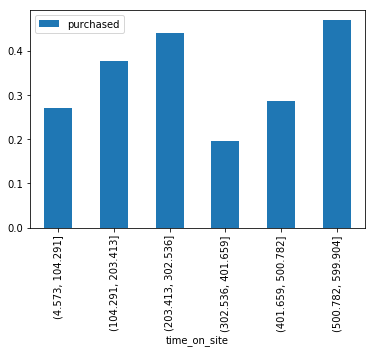

In [17]:
pt = pd.pivot_table(user_data, values='purchased', index=time_bins)
pt.plot(kind='bar', stacked=True);

In [15]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.573, 104.291]    0.181319  0.376623  0.073529  0.250000
(104.291, 203.413]  0.142857  0.333333  0.161765  0.340278
(203.413, 302.536]  0.192308  0.290043  0.220588  0.409722
(302.536, 401.659]  0.225275  0.000000  0.147059  0.000000
(401.659, 500.782]  0.164835  0.000000  0.176471  0.000000
(500.782, 599.904]  0.093407  0.000000  0.220588  0.000000

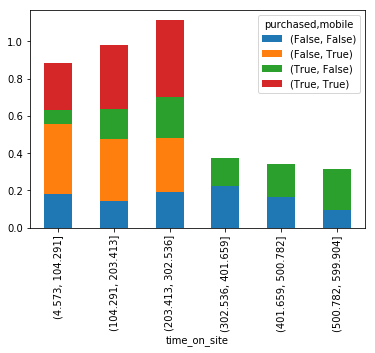

In [16]:
ct.plot(kind='bar', stacked=True)

In [0]:
dir(pd.pandas)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
import pandas as pd
url = "https://raw.githubusercontent.com/leehanchung/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv"
# use first column of persons.csv as row index
df = pd.read_csv(url, index_col = 0)

In [46]:
df.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [47]:
df.isna().any()

age              False
weight           False
exercise_time    False
dtype: bool

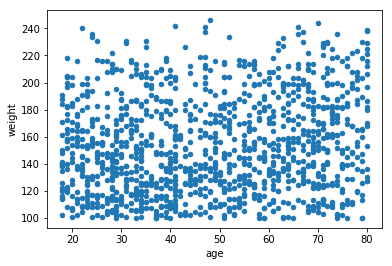

In [51]:
df.plot.scatter('age', 'weight');

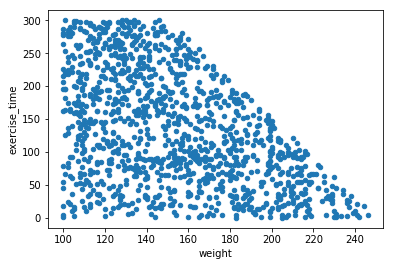

In [52]:
df.plot.scatter('weight', 'exercise_time');

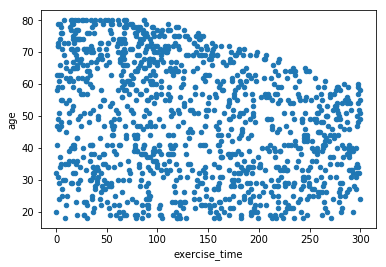

In [53]:
df.plot.scatter('exercise_time', 'age');

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)